# Artificial Intelligence Week 1

> Tags: #trees #depth-first-search #time-complexity #board-games #astar #heuristics #uniform-cost-search #priority-queue

**Author:** [Liz](https://github.com/liz-cpu), [Ramon](https://github.com/ramonkits)

In [1]:
import colorama as color
color.init(autoreset=True)
import sys
sys.path.insert(0, '../')

## 1. River crossing

> ### Assignment
> As discussed in the lecture: a farmer has a wolf, a goat, and a cabbage. She must transport himself and both animals, along with the cabbage, to the other side of the river. There is a small boat in which She can carry only one thing at a time. However, if the wolf and the goat are left alone, the wolf will eat the goat. If the goat and the cabbage are left alone, the goat will eat the cabbage. 
>
> Write a Python program that provides all solutions. It can be done in less than 80 lines. You don't need to create a GUI; a simple command-line interface (CLI) is sufficient.
>
> Here are some hints: a state represents the configuration of the left and right banks. For example, 'FGCW|' is the initial state, and '|FGCW' is the final state. A state can transition to the next state as the farmer crosses the river with an item. If we view the states as nodes and the transitions as branches, we get a tree structure that we can explore with depth-first search (DFS). Refer to the lecture slides for more details.
>
> **Question: What is the time complexity of your solution?**

### Solution

Firstly, I created a class called `Node` which represents the state of the paradox. It has the following attributes:

- `top`: a set of characters representing items on the top side of the river. This is also the initial side.
- `bottom`: a set of characters representing items on the bottom side of the river. This is also the final side.
- `farmer`: a boolean value indicating whether the boat is on the top side or not.
- `parent`: the parent state of the current state. This is used to trace back the path from the final state to the initial state.

To be able to compare two states, I implemented the `__eq__` method. It returns `True` if the two states (top, bottom, farmer's side) are the same.

The `move` method is used to move an item from one side to the other. It takes an item as an argument and returns a new state. If the item is not on the same side as the boat, it returns `None`.

`is_valid` was somehow the hardest method to implement. It checks if the state is valid or not. A state is valid if on the side where the farmer is not,
no item is eaten. The `prohibited = [set("🐐🥬"), set("🐐🐺")]` variable contains the combinations of items that are not allowed to be on the same side. Using some set theory, if checks that for the side where the farmer is not, any combination of items is not a subset of the prohibited combinations.

The `get_children` method returns a list of all states (valid or invalid) that can be reached from the current state. It does so by calling the `move` method for each item on the current side and adds this to the list **and** a child node for the farmer without any item.

In [2]:
class Node(object):
    prohibited = [set("🐐🥬"), set("🐐🐺")]

    def __init__(self, top: set[chr], bottom: set[chr], farmer: bool, parent: bool = None):
        self.top = top
        self.bottom = bottom
        self.farmer = farmer
        self.parent = parent

    def __str__(self):
        return "".join(self.top) + ("👨|" if self.farmer else "|👨") + "".join(self.bottom)

    def __eq__(self, __value: object) -> bool:
        return self.top == __value.top and self.bottom == __value.bottom and self.farmer == __value.farmer

    def move(self, item: chr):
        if self.farmer:
            self.top.remove(item)
            self.bottom.add(item)
        else:
            self.bottom.remove(item)
            self.top.add(item)
        self.farmer = not self.farmer

    def is_valid(self) -> bool:
        items_on_shore = self.bottom if self.farmer else self.top
        return not any(p.issubset(items_on_shore) for p in self.prohibited)

    def get_children(self) -> list:
        children = []
        for item in self.top if self.farmer else self.bottom:
            child = Node(self.top.copy(), self.bottom.copy(),
                         self.farmer, self)
            child.move(item)
            children.append(child)
        child = Node(self.top.copy(), self.bottom.copy(),
                     not self.farmer, self)
        children.append(child)
        return children

#### The graph

Before implementing the algorithm, I created a graph with excalidraw to visualize the problem. The graph is shown below.

White nodes are valid nodes. Red nodes are invalid nodes. Blue nodes are duplicate nodes. The dotted blue line shows the duplicate nodes.
The green node is the final state. As you can see, there are two main branches, the `C|FWG` and `W|FCG` branches. Interestingly, both branches will converge at `G|FWC`, before reaching `FG|WC` which leads to the final state, `|FWCG`.

<div>
<img src="graph.png" width="750"/>
</div>

#### The algorithm

##### Depth-first search
Depth-first search is a graph traversal algorithm that, as the name suggests, traverses the graph depth-first. It starts at the root node and explores as far as possible along each branch before backtracking. It uses a list to keep track of the nodes that have been visited in the current path. If a node has been visited, it is not visited again. If all nodes have been visited, the algorithm stops.

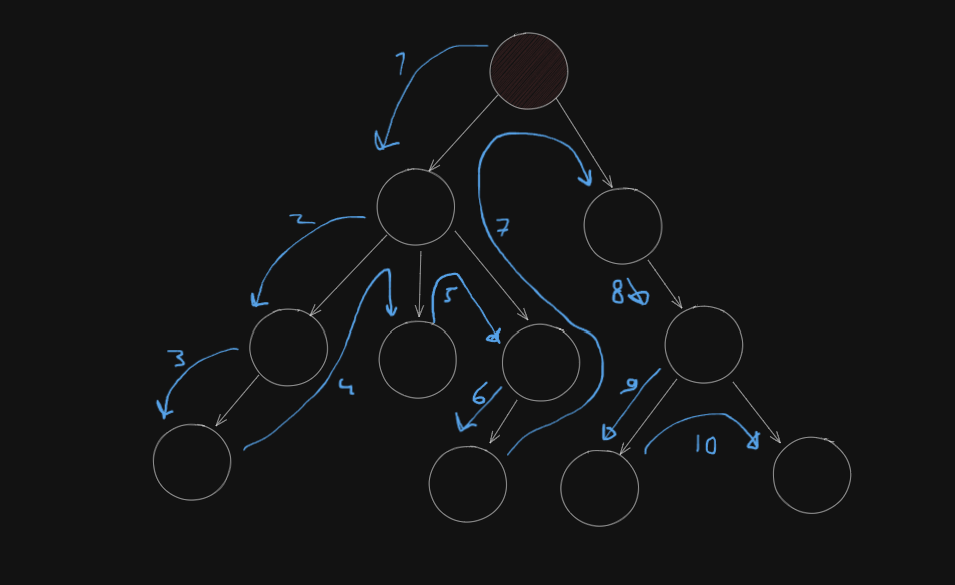

For this problem I have used a recursive implementation of the algorithm. We check at the start whether the current node is the final node. If it is, we return the path from the initial node to the final node. If it is not, we get the children of the current node and call the `dfs` method for each child. If the child is not `None`, we add the child to the path and return the path. If the child is `None`, we remove the child from the path and continue with the next child.

In [3]:
def dfs(node: Node, goal: Node, path: list = []) -> Node:
    paths = []
    if node == goal:
        path.append(node)
        paths.append(path.copy())
        path.pop()
    elif node not in path and node.is_valid():
        path.append(node)
        for child in node.get_children():
            paths += dfs(child, goal, path)
        path.pop()
    return paths

In [4]:
def print_paths(list_of_paths: list[list[Node]]):
    for idx, path in enumerate(list_of_paths):
        print(color.Fore.GREEN + "Path: " + str(idx + 1))
        print_path(path)


def print_path(path: list[Node]):
    for node in path:
        print(node)


def river_crossing(start_state: str) -> str:
    d = {"G": "🐐", "C": "🥬", "W": "🐺"}
    top, bottom = start_state.split("|")
    farmer = "F" in top.upper()
    top, bottom = top.upper().replace("F", ""), bottom.upper().replace("F", "")
    top, bottom = [d[c] for c in top], [d[c] for c in bottom]
    start_node = Node(set(top), set(bottom), farmer)
    goal_node = Node(set(), set(top + bottom), farmer)
    result = dfs(start_node, goal_node)
    if result is None:
        print(color.Fore.RED + "No solution found")
    print_paths(result)

In [5]:
start = "FGCW|"
river_crossing(start)

Path: 1
🥬🐺🐐👨|
🥬🐺|👨🐐
🥬🐺👨|🐐
🐺|👨🥬🐐
🐺🐐👨|🥬
🐐|👨🥬🐺
🐐👨|🥬🐺
|👨🥬🐺🐐
👨|🥬🐺🐐
Path: 2
🥬🐺🐐👨|
🥬🐺|👨🐐
🥬🐺👨|🐐
🥬|👨🐺🐐
🥬🐐👨|🐺
🐐|👨🥬🐺
🐐👨|🥬🐺
|👨🥬🐺🐐
👨|🥬🐺🐐


#### Time complexity

This algorithm has $O(b^d)$ time complexity, where b is the branching factor and d is the depth of the shallowest solution. A branching factor is the highest amount of children a node can have. This falls under exponential time.

The time complexity of the `print_paths` method is $O(n)$, where $n$ is the amount of nodes in the path.

---

## Board games

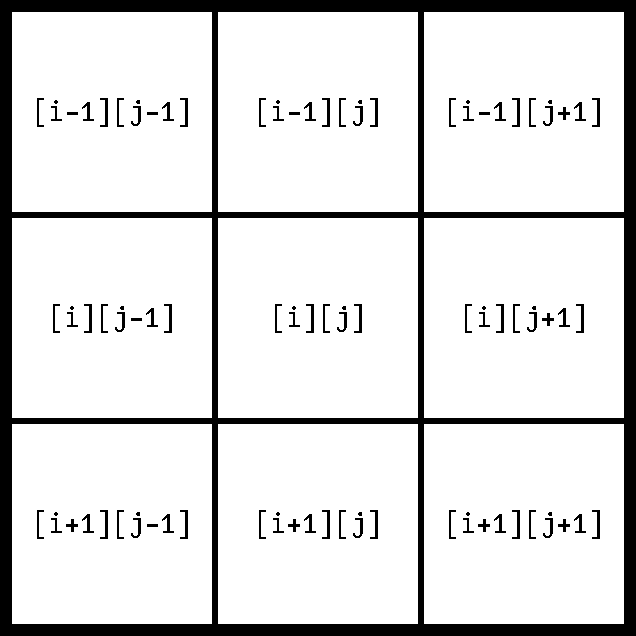

For problems that involve a board, it is useful to represent the board as a 2D array. Each cell in the array represents a state. Most of the time a neighbour function may be implemented. This function takes a state as an argument and returns a list of all possible states that can be reached from the current state. This can be done for both 4 and 8 directions. The 8 directions are shown in the image above.

Possible implementations of the neighbour function are:
- Double for loops. This is the easiest implementation, where you loop over the rows and columns and add the neighbours to a list.
- Using a list of predefined neighbours. This is useful if you want to exclude certain neighbours. For example, if you want to exclude diagonal neighbours, you can use the following list: `[(0, 1), (1, 0), (0, -1), (-1, 0)]`. This list contains the neighbours in the order: right, down, left, up. You can also use this list to implement a 4-directional neighbour function.

---

## 2. Boggle

### Assignment
> Boggle is a word game where as many words as possible must be found on an N x N board of letters. Words can be formed by creating sequences of adjacent letters. In this task, adjacency refers to horizontal or vertical connections (not diagonal), with the ability to continue from the last to the first column and from the last to the first row (and vice versa).
>
> In the 4x4 board below, for example, the words HUIS, MAT, TAS, and EI can be found:

```
┌───┬───┬───┬───┐
│ P │ I │ E │ T │
├───┼───┼───┼───┤
│ G │ A │ A │ T │
├───┼───┼───┼───┤
│ A │ T │ M │ S │
├───┼───┼───┼───┤
│ H │ U │ I │ S │
└───┴───┴───┴───┘
```


> Write a program for an NxN board, where N can vary. It can be done in fewer than 50 lines. You don't need to create a GUI; a command-line interface (CLI) based on text is sufficient.
>
> The file words.txt (available on Blackboard) contains a list of words that you can use for matching. It is useful to first create a list in memory of all possible prefixes (choose a suitable data structure for this). For example, prefixes of HUIS are H, HU, and HUI. A 'valid' state is then a sequence of letters that matches a prefix.
>
> Based on Depth-First Search (DFS), you can explore all possibilities. A path stops when the sequence of letters does not appear in the list of prefixes.
>
> Question: What is the time complexity of your solution?

In [6]:
# import the words from the file
words = []
with open("boggle/words_EN.txt") as f:
    for line in f.readlines():
        words.append(line.strip())

### Solution

I started by creating a `BoggleGame` class. It has the following attributes:
- `words`: a set of all words in the `words.txt` file.
- `board`: a 2D array representing the board.
- `prefixes`: a set of all prefixes of the words in the `words.txt` file. Could have been a trie but oh well.

In the initialization method, I read the `words.txt` all words to the `words` set. I also create the `prefixes` set by adding all prefixes of the words in the `words` set.

The `find_neighbours` method takes a position as an argument and returns a list of all valid neighbours. A neighbour is valid if it is within the bounds of the board and if it has not been visited yet.

In [7]:
class BoggleGame(object):
    words: set[str]
    board: list[list[chr]]
    prefixes: set[str]

    def __init__(self, words: list[str], board: list[list[chr]]):
        self.words = set(words)
        self.board = board
        self.prefixes = set()
        for word in self.words:
            for i in range(len(word)):
                self.prefixes.add(word[:i+1])

    def __str__(self):
        return "\n".join([" ".join(row) for row in self.board])

    def find_neighbors(self, i: int, j: int) -> list[tuple[int, int]]:
        return [(x, y) for x, y in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
                if 0 <= x < len(self.board) and 0 <= y < len(self.board[0])]

    @classmethod
    def from_str(cls, s: str):
        return cls(words, [[c for c in row] for row in s.split("\n")])

    @classmethod
    def method(cls, f):
        setattr(cls, f.__name__, f)

##### The algorithm

Again, I used a recursive implementation of the depth-first search algorithm. The algorithm starts at the first letter of the word and checks if it is in the `prefixes` set or the words set. If doesn't exist in either, the algorithm stops. 

Now we loop through all neighbours of the current position. If the neighbour has not been visited yet, we add it to the visited list. The next word is the current word plus the letter of the neighbour. Now we call the `dfs` method for this neighbour's new word.

Now because we already checked if the word exists in either the `prefixes` set or the `words` set, we can deduce that the word exists in either of them. If the last `dfs` call returns a word, we just return the word. If it doesn't, but the current word (the one with the last letter added) exists in the `words` set, we can return the current word. Becase then we have explored the deepest path possible.

The `find_words` method loops through all positions on the board and calls the `dfs` method for each position. If the `dfs` method returns a word, it is added to the `found_words` set. The `find_words` method returns the `found_words` set.

In [8]:
@BoggleGame.method
def dfs(self, i: int, j: int, visited: list[tuple[int, int]], word: str) -> str:
    if (word not in self.prefixes) and (word not in self.words):
        return None
    for x, y in self.find_neighbors(i, j):
        if (x, y) not in visited:
            visited.append((x, y))
            new_word = word + self.board[x][y]
            deeper = self.dfs(x, y, visited, new_word)
            if deeper is not None:
                return deeper
            if deeper is None and new_word in self.words:
                return new_word
            visited.pop()
    return None


@BoggleGame.method
def find_words(self) -> list[str]:
    found_words = []
    for i in range(len(self.board)):
        for j in range(len(self.board[0])):
            if (res := self.dfs(i, j, [(i, j)], self.board[i][j])) is not None:
                found_words.append(res)
    return found_words

In [9]:
board = [
    ['c', 'o', 'm', 'b'],
    ['o', 'a', 'a', 's'],
    ['m', 'a', 'b', 'a'],
    ['s', 'r', 'i', 's']
]

game = BoggleGame(words, board)
f = game.find_words()
print(f)

['coms', 'oc', 'mabi', 'bs', 'oc', 'aam', 'amb', 'sb', 'moco', 'aaa', 'bam', 'asb', 'sma', 'rams', 'iba', 'sasa']


#### Time complexity

The time complexity of this algorithm is $O(b^d)$ again, but we can see that the branching factor is 4, due to the 4 cardinal directions. Therefore, the time complexity is $O(4^{nm})$, where $n$ is the amount of rows and $m$ is the amount of columns. If the board is a square, the time complexity is $O(4^{n^2})$.

## 3. Numbrix

> ### Assignment
> This task resembles the previous one to some extent. Numbrix is a puzzle on an NxN board where the first number (1) and the last number (N*N) are given. A path must be found from 1 to the last number, but this path must pass along/over the given intermediate numbers ('keys' or 'clues'). In this case, the numbers must match the number of steps, so square '3' must be reached in step 3. A good Numbrix puzzle has exactly one solution. In the example below, the task is to find a route from 1 to 81, such that along the way, the given numbers are visited. The route can only go horizontally or vertically (not diagonally; this is sometimes called a Manhattan path).
> 
> 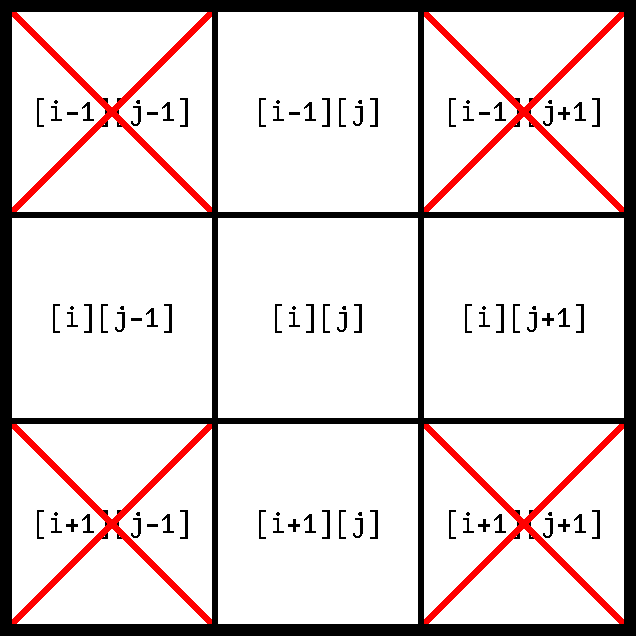
> 
> 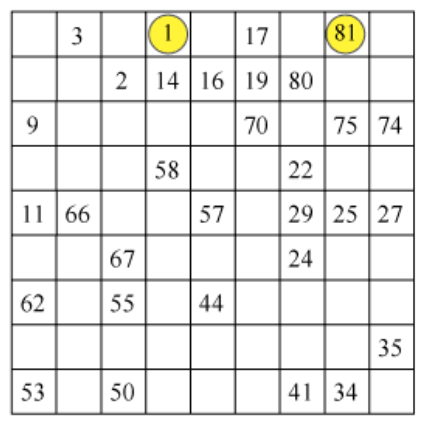
> 
> You will need the following:
> 
> - a representation of the board (or grid); consider how to easily find the neighbors of a cell and how to represent an empty cell;
> 
> - a function that returns the neighbors of a cell;
> 
> - a function that prints the board (in text) on the screen;
> 
> - a function that finds the solution (a path from 1 to NxN via the clues).
>
> Test your program with the grids, where 0 represents an empty cell:
> 
```
s = """
0  0  0  0  0  0  0  0 81
0  0 46 45  0 55 74  0  0
0 38  0  0 43  0  0 78  0
0 35  0  0  0  0  0 71  0
0  0 33  0  0  0 59  0  0
0 17  0  0  0  0  0 67  0
0 18  0  0 11  0  0 64  0
0  0 24 21  0  1  2  0  0
0  0  0  0  0  0  0  0  0
"""
```
> 
> #### Strategy
> Using DFS, we can explore all possible paths. It is helpful to fill empty cells with a 'step counter' along the way. When backtracking, we need to adjust the values of this step counter (but not the clues!).
> 
> The challenge here is determining when a path is invalid. Visiting the same cell twice is certainly invalid. A path is also invalid when visiting a cell with a clue, and the value of the clue is not equal to that of the 'step counter'. For example, in the grids below, clue values 1, 5, and 9 are given. The first two paths are invalid, and the last path is valid.
> 
> 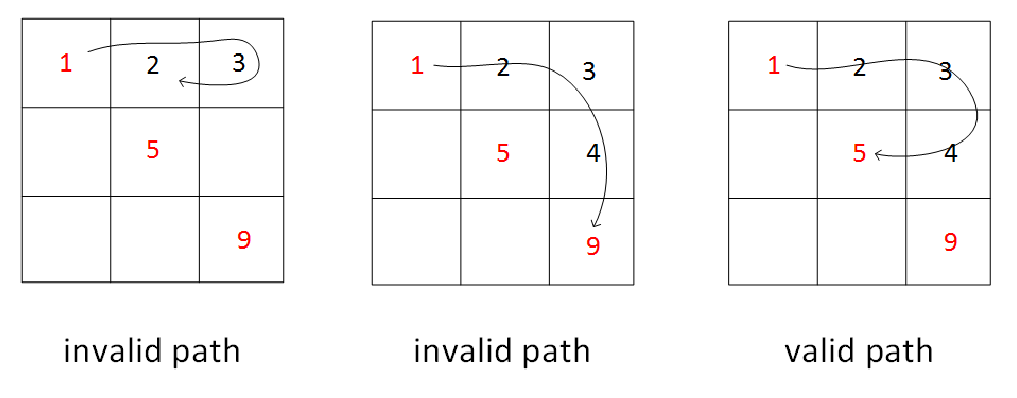
> 
> A possible algorithm based on DFS (in pseudocode) is as follows:

```python
# using DFS to traverse all paths
function solve(position, stepcount, list):
    if valid path:
        update the board and continue
    else:
        return
    if found the last clue nxn:
        # we're done, found a solution
        print(path)
        return
    for n in neighbors(position):
        # try all neighbors, increase the step count
        solve(n, stepcount+l, next_clue_in_list)
        solve(first_position, 1, next_clue_in_list)
```

> Question: What is the time complexity of your solution?


### Solution

We start off again by creating a `NumbrixBoard` class. It has the following attributes:
- `board`: a 2D array representing the boards, initialized with the hints.
- `size`: the size of the board. Assumed to be a square.
- `start`: the location of the start number.
- `end`: the location of the end number, which is also the size squared.

In [10]:
class NumbrixBoard(object):
    def __init__(self, hints: list[list[str]]):
        self.board = hints
        self.size = len(hints)
        self.start = self.find_in_board("1")
        self.end = self.find_in_board(str(self.size**2))

    def __str__(self):
        result = ""
        for row in self.board:
            result += "|".join(str(cell).center(3) for cell in row) + "\n"
            result += "-" * (self.size * 4 - 1) + "\n"
        return result

    def __repr__(self):
        return f"NumbrixBoard(hints={self.board})"

    def find_in_board(self, num: str) -> tuple[int, int] | None:
        for i in range(len(self.board)):
            for j in range(len(self.board[0])):
                if self.board[i][j] == num:
                    return (i, j)
        return None

    def get_neighbors(self, i: int, j: int) -> list[tuple[int, int]]:
        neighbors = []
        for x, y in [(i - 1, j), (i, j - 1), (i + 1, j), (i, j + 1)]:  # O(1).
            if 0 <= x < self.size and 0 <= y < self.size:
                neighbors.append((x, y))
        return neighbors

    @classmethod
    def method(cls, f):
        setattr(cls, f.__name__, f)

    @classmethod
    def from_str(cls, board: str):
        lines = board.strip().split('\n')
        b = [[cell if cell != '0' else ' ' for cell in line.split()]
             for line in lines]
        return cls(b)

#### The algorithm

The algorithm is very similar to the algorithm of the previous problem, with it also being a recursive implementation of the depth-first search algorithm. The algorithm starts at the start number and checks if the neighbours' values are equal to the current count or an empty cell. If it is an empty cell, we update the board with the current count and call the `dfs` method for this neighbour's new count. If it is equal to the current count, we call the `dfs` method for this neighbour's new count. If it is not equal to the current count, we return False.

We return the newly filled board if the current count is equal to the end. Recursively, we return the board if the `dfs` method returns a board.

As is stated in the assignment, a good Numbrix puzzle has exactly one solution. Therefore, we can stop the algorithm if the `dfs` method returns a board.

In [11]:
@NumbrixBoard.method
def dfs(
    self,
    visited: list[tuple[int, int]] = [],
    num: int = 1,
    coords: tuple[int, int] = None,
    current_board: list[list[str]] = None,
) -> bool:
    i, j = coords or self.start
    current_board = current_board or [
        [self.board[i][j] for j in range(self.size)] for i in range(self.size)
    ] 
    for x, y in self.get_neighbors(i, j):
        if (x, y) in visited:
            continue
        if (x, y) == self.end and num == self.size**2 - 1:
            return current_board
        neigh_num = int(
            self.board[x][y]) if self.board[x][y] != " " else num + 1
        if (x, y) not in visited and neigh_num == num + 1:
            current_board[x][y] = str(num + 1)
            visited.append((x, y))
            if b := self.dfs(visited, num + 1, (x, y), current_board):
                return b
            visited.pop()
    return False

In [12]:

print(NumbrixBoard.from_str("""
0  0  0  0  0  0  0  0 81
0  0 46 45  0 55 74  0  0
0 38  0  0 43  0  0 78  0
0 35  0  0  0  0  0 71  0
0  0 33  0  0  0 59  0  0
0 17  0  0  0  0  0 67  0
0 18  0  0 11  0  0 64  0
0  0 24 21  0  1  2  0  0
0  0  0  0  0  0  0  0  0
"""
).dfs())

[['49', '50', '51', '52', '53', '54', '75', '76', '81'], ['48', '47', '46', '45', '44', '55', '74', '77', '80'], ['37', '38', '39', '40', '43', '56', '73', '78', '79'], ['36', '35', '34', '41', '42', '57', '72', '71', '70'], ['31', '32', '33', '14', '13', '58', '59', '68', '69'], ['30', '17', '16', '15', '12', '61', '60', '67', '66'], ['29', '18', '19', '20', '11', '62', '63', '64', '65'], ['28', '25', '24', '21', '10', '1', '2', '3', '4'], ['27', '26', '23', '22', '9', '8', '7', '6', '5']]


#### Time complexity

The time complexity of this algorithm is the same as the previous algorithm, $O(4^{n^2})$.

---

## A* and Uniform Cost Search

A* and Uniform Cost Search are algorithms that are used to find the shortest path between two nodes in a graph. Both of them have a common ancestor, the Dijkstra algorithm. While based on the same algorithm, they differ in the way they calculate the cost of a node.

Implementations of both algorithms use a data structure called a priority queue. A priority queue is a data structure that stores items in a queue. However, the items are ordered by priority. The item with the highest priority is at the front of the queue. The item with the lowest priority is at the back of the queue.



In [13]:
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

---

## 4. Grid Pathfinding
### Assignment
> The task is to find a path based on the A* algorithm from the top left (start) to the bottom right (goal). The red-marked points represent obstacles, so the path cannot pass through them. The discovered path should be displayed in blue. The points visited along the way (i.e., those in the queue) should be shown in light blue.
>
> 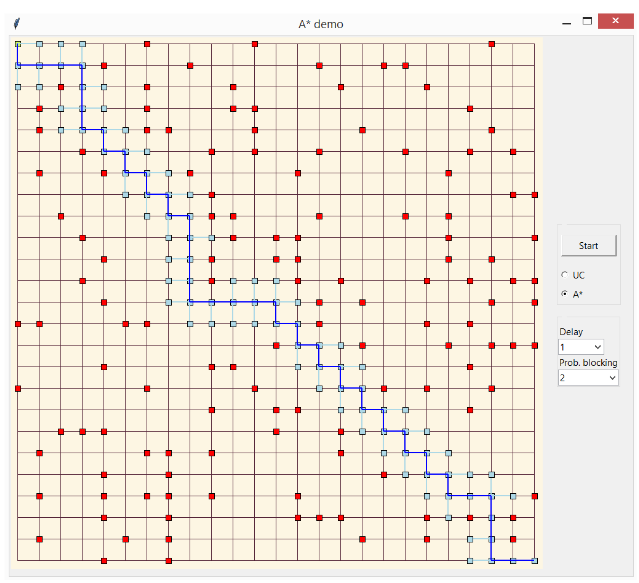
> 
> The PriorityQueue class from model.py can be used in the A* algorithm. You will also need to think about a suitable heuristic to estimate the distance to the goal node. It is important to ensure that this estimation is always optimistic (i.e., 'consistent').
> 
> You should be able to demonstrate the difference between UCS and A*, highlighting the added value of a heuristic. Furthermore, the delay and the probability of a blocking node should be adjustable using the combo boxes.
> 
> On Blackboard, you can find the file a_star_start.zip with 3 Python files. The function search(app, start, goal) needs to be modified. This can be done in approximately 50 lines of code.

### Solution

Because most of the code was already provided, I only had to implement the `search` method. The `search` method will redirect to the `a_star` method if the algorithm is A* or to the `ucs` method if the algorithm is UCS.

#### The `ucs` method

In [14]:
def ucs(app, start, goal):
    frontier = PriorityQueue()
    visited = set()
    frontier.put(start, 0)
    came_from = {}  # To store the parent node for each explored node
    cost_so_far = {start: 0}  # To store the cost to reach each explored node

    while not frontier.empty():
        current = frontier.get()

        if current == goal:
            # Reconstruct the path and plot it
            path = reconstruct_path(came_from, start, goal)
            for node in path:
                app.plot_node(node, color=cf.FINAL_C)
                app.pause()
            return

        visited.add(current)

        for next_node in get_neighbors(current):
            new_cost = cost_so_far[current] + 1

            if next_node not in visited and (next_node not in cost_so_far or new_cost < cost_so_far[next_node]):
                cost_so_far[next_node] = new_cost
                frontier.put(next_node, new_cost)
                came_from[next_node] = current
                app.plot_node(next_node, color=cf.PATH_C)
                app.pause()
    return

#### The `a_star` method

In [15]:
def h(start, goal):
    return math.sqrt((start[0] - goal[0]) ** 2 + (start[1] - goal[1]) ** 2)

def a_star(app, start, goal):
    """
    A* Search
    Heuristic search algorithm
    """
    frontier = PriorityQueue()
    visited = set()
    frontier.put(start, 0)
    came_from = {}  # To store the parent node for each explored node
    cost_so_far = {start: 0}  # To store the cost to reach each explored node

    while not frontier.empty():
        current = frontier.get()

        if current == goal:
            # Reconstruct the path and plot it
            path = reconstruct_path(came_from, start, goal)
            for node in path:
                app.plot_node(node, color=cf.FINAL_C)
                app.pause()
            return

        visited.add(current)

        for next_node in get_neighbors(current):
            new_cost = cost_so_far[current] + 1
            if next_node not in visited and (next_node not in cost_so_far or new_cost < cost_so_far[next_node]):
                cost_so_far[next_node] = new_cost
                priority = new_cost + h(next_node, goal)  # A* uses the sum of cost and heuristic as priority
                frontier.put(next_node, priority)
                came_from[next_node] = current
                app.plot_node(next_node, color=cf.PATH_C)
                app.pause()
    return

#### Verschillen

Het is te zien dat A star betere performance heeft dan UCS. DIt komt omdat A star een heuristiek gebruikt om de afstand tot het doel te schatten. Hierdoor worden nodes die verder van het doel liggen eerder bezocht. UCS bezoekt alle nodes in de volgorde van de afstand tot de start node wat minder efficient is.

De implementatie van A star heeft een heuristiek die altijd optimistisch is. Dit betekent dat de heuristiek altijd kleiner is dan de werkelijke afstand tot het doel. Dit is belangrijk omdat anders de optimale oplossing niet gegarandeerd is.

**UCS**

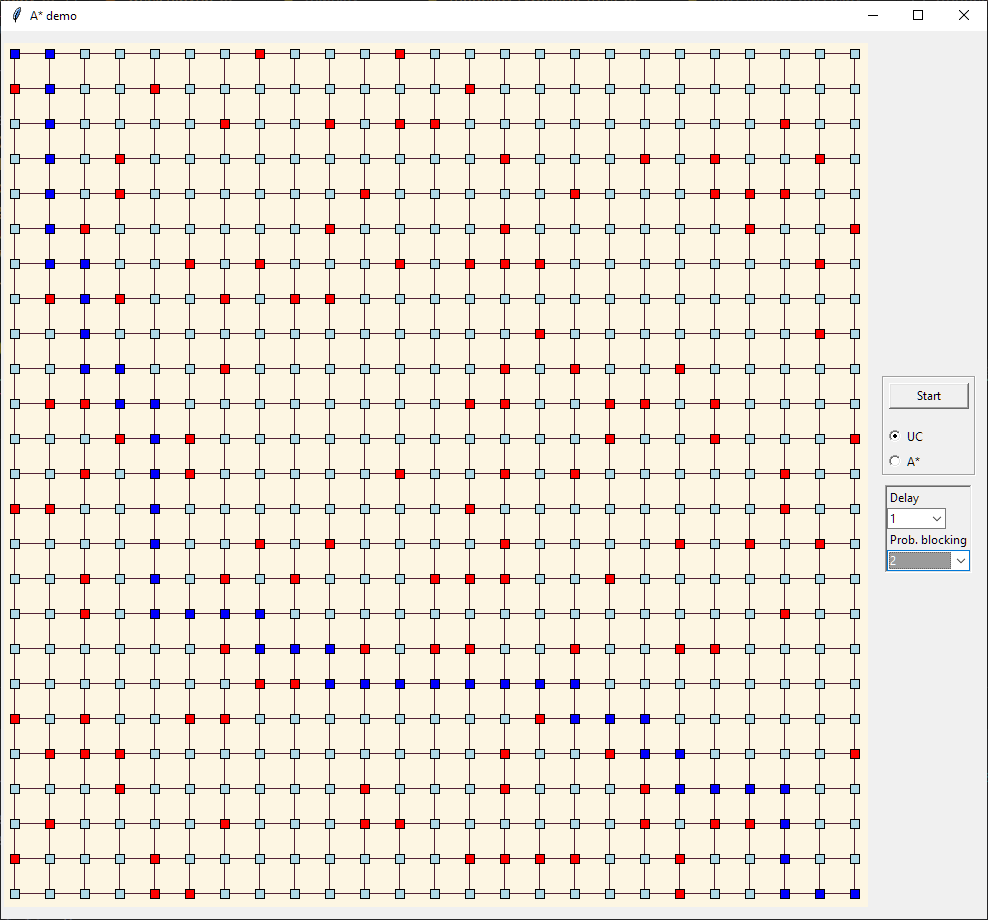

**A star**

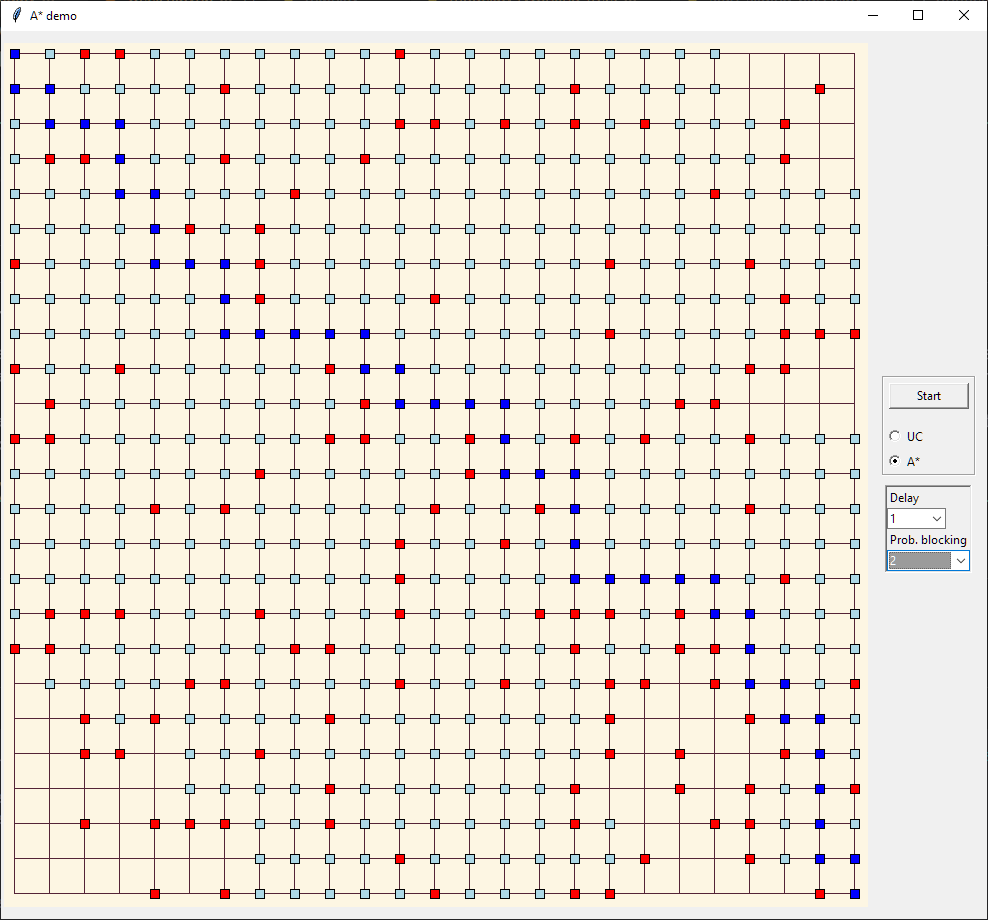

Op te merken is dat het gevonden pad van UCS meestal lange rechte lijnen zijn. Dit komt omdat UCS alle nodes in de volgorde van de afstand tot de start node bezoekt. Hierdoor worden eerst alle nodes in een rechte lijn bezocht. Pas daarna worden de nodes die verder van de start node liggen bezocht. Dit is ook de reden dat UCS een langere tijd nodig heeft om het pad te vinden.
Bij A* is een meer diagonaal pad te zien. Dit komt omdat A* een heuristiek, namelijk de euclidische afstand, gebruikt om de afstand tot het doel te schatten. Hierdoor worden nodes die verder van het doel liggen eerder bezocht. Dit verklaart ook waarom A* een kortere tijd nodig heeft om het pad te vinden.



## 5. Sliding Puzzle

> The sliding puzzle is a puzzle on a board of (usually) 15 square tiles and an empty space. In the standard variant, the numbers 1 to 15 are on the 15 tiles. This puzzle was a craze in America and Europe around 1880. The puzzle also exists in other variants, with the most well-known being the 8-puzzle with 3 x 3 tiles.
> 
> In each move, a tile can be slid into the empty space, thereby swapping the positions of the tile and the empty space. The N x N variant is a well-known mathematical problem and is sometimes used to explore various heuristic functions.
> 
> This task is similar to the previous one and can also be solved with A*. The challenge lies in finding a suitable (not too complex) heuristic function to estimate the distance from any board (start state) to the goal board (goal state). Configure your program so that the heuristic function can be toggled, allowing the performance difference between UCS and A* to be demonstrated.
> 
> The goal board is as follows:

```
+---+---+---+
| 1 | 2 | 3 |
+---+---+---+
| 4 | 5 | 6 |
+---+---+---+
| 7 | 8 | 0 |
+---+---+---+
```

> Here, '0' represents the empty space. Not every starting board has a solution; a known starting board is:

```
+---+---+---+
| 8 | 6 | 7 |
+---+---+---+
| 2 | 5 | 4 |
+---+---+---+
| 3 | 0 | 1 |
+---+---+---+
```

> Modify the program so that it works not only for the above 3x3 boards but for any NxN board, where N can vary. On Blackboard, you can find the file "start-sliding-puzzle.py" to help you get started. It can be done in less than 80 lines. You don't need to create a GUI; a command-line interface (CLI) is sufficient. A possible (partial) output is as follows:


```
D:\Jacob\Python\games\Sliding puzzle>python eight_sliding_puzzle_astar.py

the start> 867 254 301
the goal> 123 456 780

nr states visited: 31

867
254
301

867
254
310

867
250
314

867
205
314
```

$ h(n) = \sum_{i=0}^{SIZE} \left( \lvert \frac{i}{N} - \frac{{\text{{state}}[i] - 1}}{N} \rvert + \lvert \frac{i \mod N - ({\text{{state}}[i] - 1}) \mod N}{N} \rvert \right) $

### Solution


In [16]:
def swap(state, hole, neighbor):
    # input is a board (list), returns a board where hole and neighbor are swapped
    s = state[:]  # make a local copy
    s[hole], s[neighbor] = s[neighbor], s[hole]
    return s


def neighbors(state):
    # input is a board (flat list), returns a tuple of 2..4 neighboring states, depending on the hole
    n = ()  # tuple with neighboring states
    # find index of hole in s
    i = state.index(0)
    row = i//N  # [0..N-1]
    # up or down: neighbor in [0..N*N]? then add to tuple
    if i-N >= 0:
        n = n + (swap(state, i, i-N),)
    if i+N < SIZE:
        n = n + (swap(state, i, i+N),)
    # left or right: neigbor in current row? then add to tuple
    if i-1 >= row*N:
        n = n + (swap(state, i, i-1),)
    if i+1 < (row+1)*N:
        n = n + (swap(state, i, i+1),)
    return n


def is_goal(state):
    # input is a board (list), returns True if the board is the goal board
    return all(state[i] == i+1 for i in range(SIZE-1)) and state[SIZE-1] == 0

Firstly we implement UCS. Here we take the cost of a node to simply be the depth of the node. We use a priority queue to keep track of the nodes that have been visited. We also use a set to keep track of the nodes that have been visited. This is to prevent visiting the same node twice. We also use a dictionary to keep track of the parent of each node. This is to be able to trace back the path from the goal node to the start node.

In [17]:
def ucs(start):
    # input is a start state (list), returns the path to the goal state
    # path is a dictionary tuple_state => tuple_parent_state

    frontier = PriorityQueue()
    frontier.put(start, 0)
    path = {tuple(start): None}  # dictionary to store the path
    cost = {tuple(start): 0}  # dictionary to store the cost

    while not frontier.empty():
        current_state = frontier.get()

        if is_goal(current_state):
            return path, cost[tuple(current_state)]

        for neighbor_state in neighbors(current_state):
            new_cost = cost[tuple(current_state)] + 1

            if tuple(neighbor_state) not in cost or new_cost < cost[tuple(neighbor_state)]:
                cost[tuple(neighbor_state)] = new_cost
                priority = new_cost
                frontier.put(neighbor_state, priority)
                path[tuple(neighbor_state)] = current_state

    return None, 0  # No path found

Now we implement A*. We work fundamentally the same as UCS, but we use a heuristic function to estimate the distance to the goal node. We use the Manhattan distance as a heuristic function. The Manhattan distance is the sum of the horizontal and vertical distance between two points. We use the Manhattan distance to estimate the distance between the current node and the goal node.

In [18]:
def heuristic(state: list[chr]) -> int:
    """
    Calculates the heuristic value of a state
    :param state: The state to calculate the heuristic value of
    :return: The heuristic value of the state
    """
    return sum(abs(i // N - (state[i] - 1) // N) + abs(i % N - (state[i] - 1) % N) for i in range(SIZE) if state[i] != 0)

def astar(start):
    # input is a start state (list), returns the path to the goal state
    # path is a dictionary tuple_state => tuple_parent_state

    frontier = PriorityQueue()
    frontier.put(start, 0)
    path = {tuple(start): None}  # dictionary to store the path
    cost = {tuple(start): 0}  # dictionary to store the cost

    while not frontier.empty():
        current_state = frontier.get()

        if is_goal(current_state):
            return path, cost[tuple(current_state)]

        for neighbor_state in neighbors(current_state):
            new_cost = cost[tuple(current_state)] + 1

            if tuple(neighbor_state) not in cost or new_cost < cost[tuple(neighbor_state)]:
                cost[tuple(neighbor_state)] = new_cost
                priority = new_cost + heuristic(neighbor_state)
                frontier.put(neighbor_state, priority)
                path[tuple(neighbor_state)] = current_state

    return None, 0  # No path found

#### Output
```
=======UCS=======
nr states visited: 31
867
254
301

867
204
351

807
264
351

870
264
351

874
260
351

874
206
351

874
026
351

874
326
051

874
326
501

874
326
510

874
320
516

874
302
516

874
032
516

074
832
516

704
832
516

740
832
516

742
830
516

742
803
516

742
813
506

742
813
056

742
013
856

042
713
856

402
713
856

412
703
856

412
753
806

412
753
086

412
053
786

012
453
786

102
453
786

120
453
786

123
450
786

123
456
780
```
```
=======A*=======
nr states visited: 31
867
254
301

867
254
310

867
250
314

867
205
314

807
265
314

870
265
314

875
260
314

875
206
314

875
216
304

875
216
034

875
016
234

075
816
234

705
816
234

715
806
234

715
836
204

715
836
024

715
036
824

015
736
824

105
736
824

135
706
824

135
726
804

135
726
840

135
720
846

130
725
846

103
725
846

123
705
846

123
745
806

123
745
086

123
045
786

123
405
786

123
450
786

123
456
780

```

Here you can see that UCS and A* have the same amount of nodes visited. However, they have different methods of finding the path. This may suggest that using a heuristic function on a small board like this is not very useful.